In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import OneClassSVM
from numpy import where
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [4]:
diabdata = pd.read_csv('diabetes_dataset__2019.csv')

In [5]:
diabdata.head(20)

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
0,50-59,Male,no,yes,one hr or more,39.0,no,no,8,6,no,occasionally,sometimes,high,0.0,0,not much,no
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,8,6,yes,very often,sometimes,normal,0.0,0,not much,no
2,40-49,Male,no,no,one hr or more,24.0,no,no,6,6,no,occasionally,sometimes,normal,0.0,0,not much,no
3,50-59,Male,no,no,one hr or more,23.0,no,no,8,6,no,occasionally,sometimes,normal,0.0,0,not much,no
4,40-49,Male,no,no,less than half an hr,27.0,no,no,8,8,no,occasionally,sometimes,normal,0.0,0,not much,no
5,40-49,Male,no,yes,none,21.0,no,yes,10,10,no,occasionally,sometimes,high,0.0,0,not much,yes
6,less than 40,Male,no,no,one hr or more,24.0,no,no,8,8,no,occasionally,sometimes,normal,0.0,0,not much,no
7,less than 40,Male,no,no,less than half an hr,20.0,no,no,7,7,yes,occasionally,sometimes,low,0.0,0,not much,no
8,40-49,Male,yes,no,one hr or more,23.0,no,no,7,7,no,occasionally,sometimes,normal,0.0,0,not much,no
9,less than 40,Male,no,no,more than half an hr,20.0,no,no,8,8,o,occasionally,sometimes,normal,0.0,0,not much,no


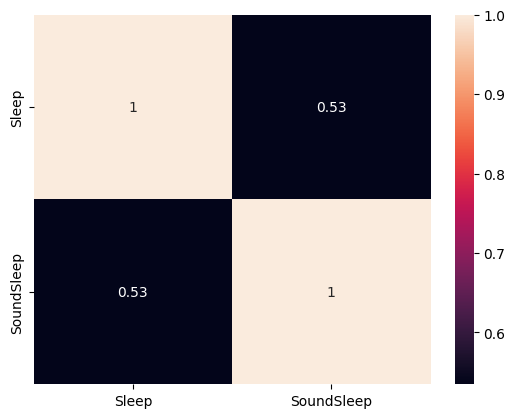

In [6]:
corr_sleep_df = diabdata[['Sleep', 'SoundSleep']] #select sleep and soundsleep
corr_sleep_mat = corr_sleep_df.corr() #correlation matrix btw two variables
sns.heatmap(corr_sleep_mat, annot=True)
plt.show()

In [7]:
#compute a simple cross tabulation of two (or more) factors
cross_tab_junk_stress = pd.crosstab(diabdata['JunkFood'], diabdata['Stress']) 
#want only first two values of tuple returned from chi2_contingency
#This function computes the chi-square statistic and p-value for the 
#hypothesis test of independence of the observed frequencies in the contingency table
chi2, p_value, df, expvals = chi2_contingency(cross_tab_junk_stress)
print("Chi-square:", chi2)
print("P-value:", p_value)
#We can assume from the low p value that junk food and stress are associated
#However, we will use both since their nature is different

Chi-square: 94.09466967499688
P-value: 2.4470337530291514e-16


In [8]:
cross_tab_junk_blood = pd.crosstab(diabdata['JunkFood'], diabdata['BPLevel']) 
chi2, p_value, df, expvals = chi2_contingency(cross_tab_junk_blood)
print("Chi-square:", chi2)
print("P-value:", p_value)
#Here, we see that junk food as blood pressure are not that highly correlated because the p-val > 0.05
#The chi-square value is also relatively low, demonstraing the above

Chi-square: 24.951722830335264
P-value: 0.05059555690352423


In [9]:
cross_tab_high_blood = pd.crosstab(diabdata['highBP'], diabdata['BPLevel']) 
chi2, p_value, df, expvals = chi2_contingency(cross_tab_high_blood)
print("Chi-square:", chi2)
print("P-value:", p_value)
#As expetced, the variables highBP and BPlevels are highly correlated because they relate both to blood pressure
#Because of the extremely high chi-square and low p-val we are likely to omit one of the two

Chi-square: 482.23875003776743
P-value: 5.439974203257661e-102


In [10]:
diabdata.dropna(subset = ['BMI', 'Sleep', 'SoundSleep'], inplace=True) #drops nan values from quantitative variables for now
diab_quant = diabdata[['BMI', 'Sleep', 'SoundSleep']] #the quantiative variables we want
target = diabdata['Diabetic'] #the label we want to predict
lab_encoder = LabelEncoder() #encode target labels with value between 0 and n_classes-1
target = lab_encoder.fit_transform(target) #transform target lab encoded
#split into 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(diab_quant, target, test_size = 0.2, random_state = 12)
#knn instant with 5 neighbors
knn_classifier = KNeighborsClassifier(n_neighbors = 5)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test) #show original yes/no's instead of 1/2's
predicted = lab_encoder.inverse_transform(y_pred)
true = lab_encoder.inverse_transform(y_test)
for pred, true in zip(predicted, true):
    print(f"Predicted: {pred}\tTrue: {true}")

Predicted: no	True: no
Predicted: no	True: yes
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: yes	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: yes	True: no
Predicted: no	True: no
Predicted: no	True: yes
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: no	True: yes
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: yes
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: no	True: no
Predicted: no	True: yes
Predicted: no	True: no
Predicted: n

In [11]:
true_labs = lab_encoder.inverse_transform(y_test) #there was an issue if I didn't inverse transform
predicted = predicted
conf_mat = confusion_matrix(true_labs, predicted)
conf_mat

array([[121,  18],
       [ 23,  28]], dtype=int64)

In [12]:
acc_sco = accuracy_score(true_labs, predicted)
acc_sco

0.7842105263157895

In [13]:
XMLP = diabdata.drop('Diabetic', axis=1)
yMLP = diabdata['Diabetic']
cat_MLP = ['Gender', 'Family_Diabetes', 'PhysicallyActive', 'Smoking', 'Alcohol', 'JunkFood', 'BPLevel']
num_MLP = ['BMI','Sleep','SoundSleep']
#encode categorical variables and scale quantitative
preprocessor_MLP = ColumnTransformer(transformers = [
    ('cat', OneHotEncoder(), cat_MLP),
    ('num', StandardScaler(), num_MLP)
])
XMLP_preproc = preprocessor_MLP.fit_transform(XMLP) #apply preprocessing

#train-test 80-20
X_trainMLP, X_testMLP, y_trainMLP, y_testMLP = train_test_split(XMLP_preproc, yMLP, test_size=0.2, random_state=12)
#using standard MLPClassifier activation and solver, as well as hidden layer sizes of 100 neurons for 2 layers
mlp = MLPClassifier(hidden_layer_sizes = (100,100), activation = 'relu', 
                    solver = 'adam', random_state = 12, max_iter=300)

mlp.fit(X_trainMLP, y_trainMLP)
y_predMLP = mlp.predict(X_testMLP)
accMLP = np.mean(y_predMLP == y_testMLP)
accMLP

0.9631578947368421

In [32]:
from sklearn.model_selection import GridSearchCV

activations = ['relu', 'logistic']
solvers = ['sgd', 'adam']
max_iterations = [1000,1100,1200]
hidden_layer_siz = [(5, 7), (7, 13), (13, 10), (100,100)]
learning_rates = 0.01 * np.arange(1, 3)

param_grid = dict(learning_rate_init = learning_rates, hidden_layer_sizes = hidden_layer_siz, max_iter = max_iterations, activation = activations, solver = solvers)
# set model
mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'logistic', learning_rate_init = 0.3, batch_size = 100, hidden_layer_sizes = (12, 3), max_iter = 500)

# For Grid Search
grid = GridSearchCV(estimator = mlp, param_grid = param_grid)

grid.fit(X_trainMLP,y_trainMLP)

print("Optimal Hyper-parameters : ", grid.best_params_)
print("Optimal Accuracy : ", grid.best_score_)

c:\Users\jpsal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Optimal Hyper-parameters :  {'activation': 'logistic', 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.02, 'max_iter': 1000, 'solver': 'adam'}
Optimal Accuracy :  0.922168002788428


[7.33986837] [[-0.01601273]]
Degree  1  Training RMSE:  1.2666461664387465
Training R2:  0.005187042859310598
[7.33986837] [[-0.01601273]]
Degree  1  Testing RMSE:  1.2898506872754183
Testing R2:  -0.015662830974160435


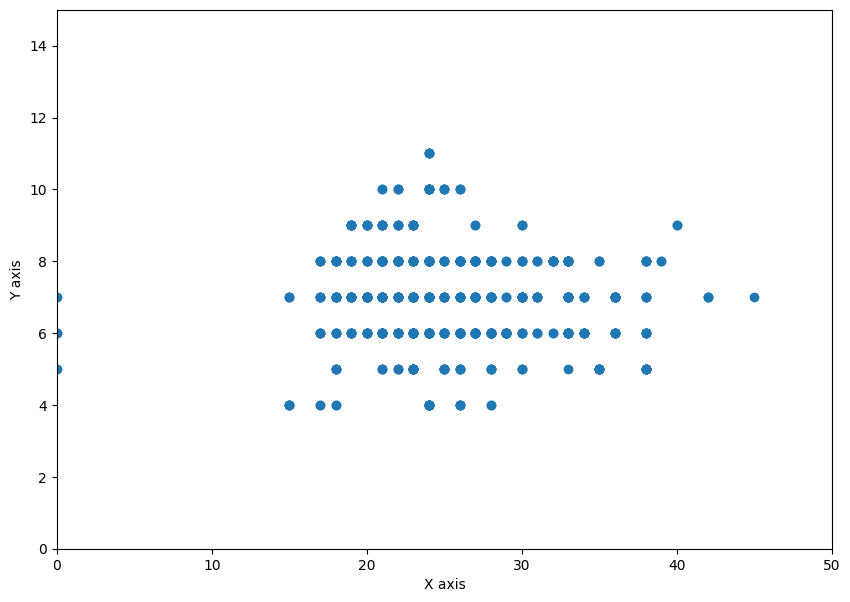

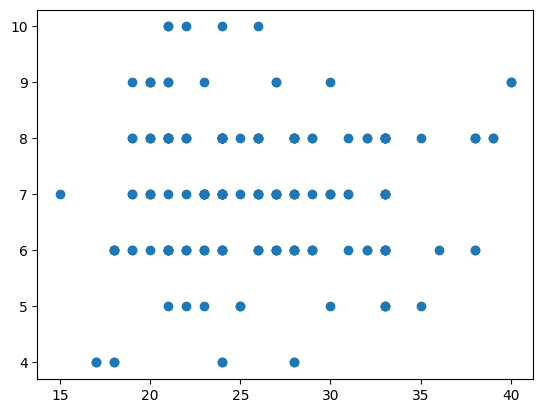

[6.17310614] [[ 0.0784566  -0.00181925]]
Degree  2  Training RMSE:  1.2617115100016216
Training R2:  0.012923217057146719
[6.17310614] [[ 0.0784566  -0.00181925]]
Degree  2  Testing RMSE:  1.2944497045391694
Testing R2:  -0.022918520884438243


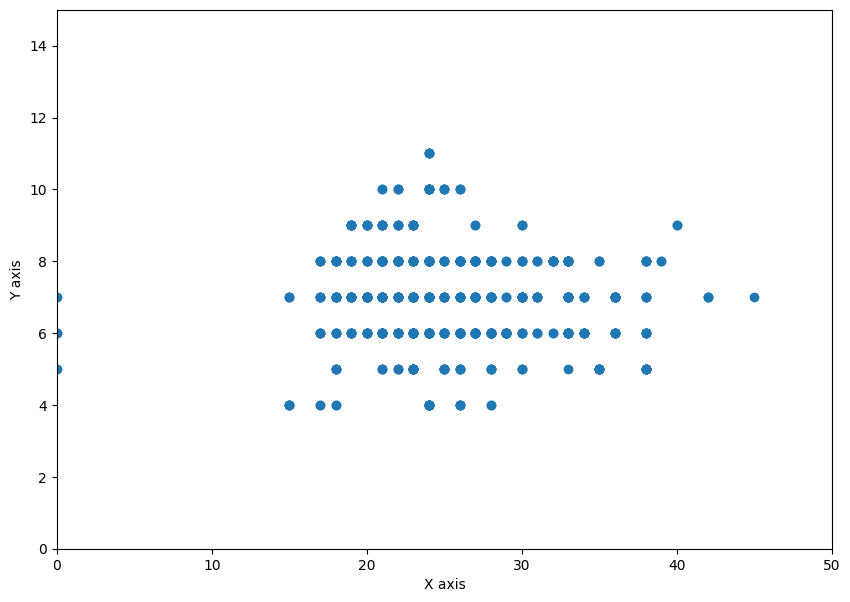

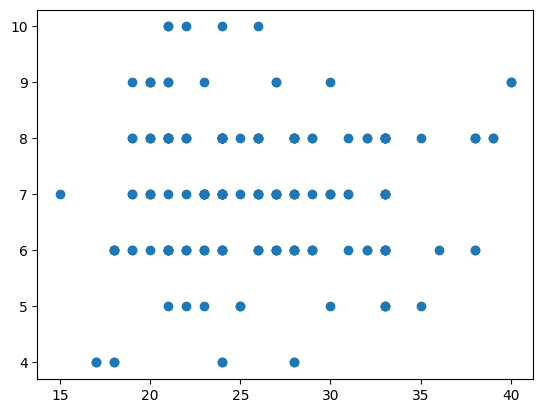

[5.62283175] [[ 1.90766248e-01 -7.68418025e-03  8.85630911e-05]]
Degree  3  Training RMSE:  1.2594685171562126
Training R2:  0.01642962590374264
[5.62283175] [[ 1.90766248e-01 -7.68418025e-03  8.85630911e-05]]
Degree  3  Testing RMSE:  1.289704879967529
Testing R2:  -0.015433218827090922


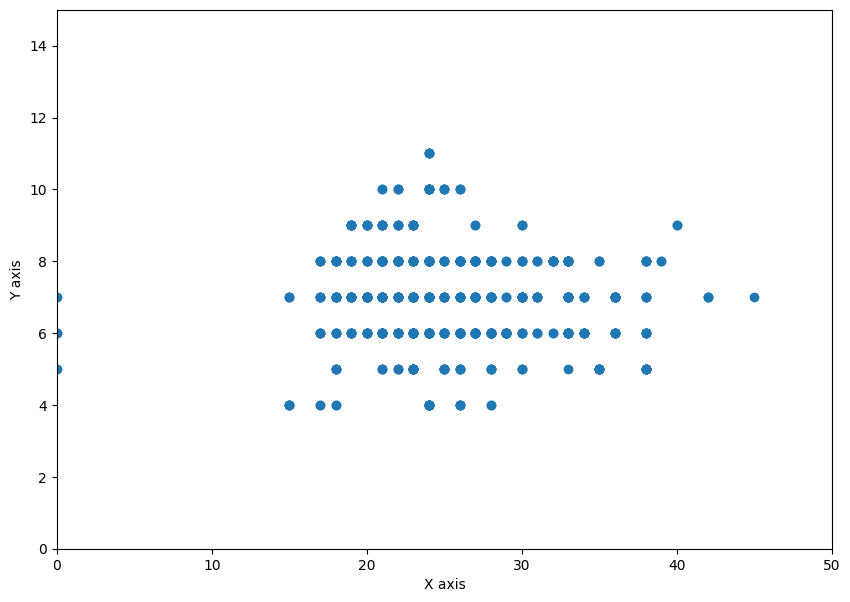

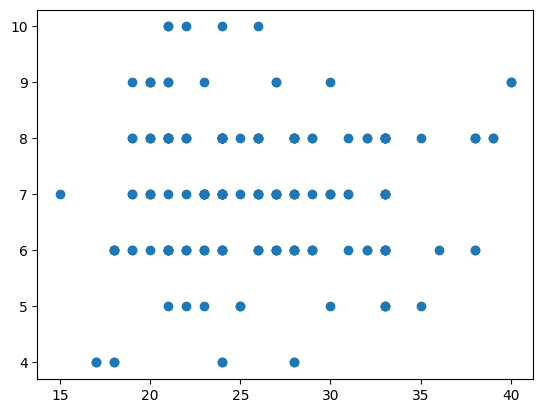

[5.87133334] [[-1.35007718e-01  2.57287255e-02 -1.06066140e-03  1.29033266e-05]]
Degree  4  Training RMSE:  1.2553332380603202
Training R2:  0.022877839098169095
[5.87133334] [[-1.35007718e-01  2.57287255e-02 -1.06066140e-03  1.29033266e-05]]
Degree  4  Testing RMSE:  1.2776339847373364
Testing R2:  0.0034855711619083962


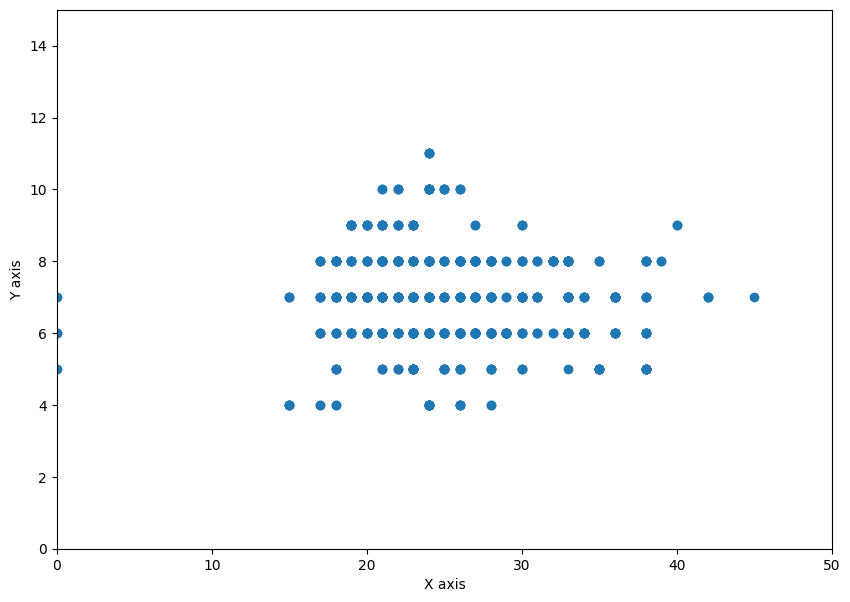

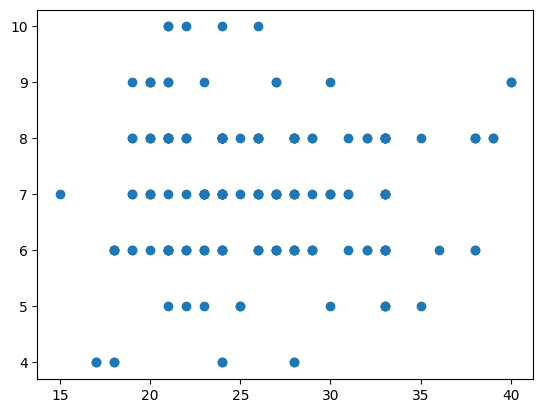

In [24]:
df = pd.read_csv('diabetes_dataset__2019.csv')
df = df.drop(columns=['Age', 'Gender', 'Family_Diabetes', 'highBP', 'PhysicallyActive', 'Smoking', 'Alcohol', 'SoundSleep', 'RegularMedicine', 'JunkFood', 'Stress', 'BPLevel', 'Pregancies', 'Pdiabetes', 'UriationFreq', 'Diabetic'])
df = df.sort_values('BMI')
df = df.fillna(0)
train, test = train_test_split(df, test_size=0.2, random_state=21)
train = train.sort_values('BMI')
test = test.sort_values('BMI')
X_train, y_train = train.drop(columns=['Sleep']), train['Sleep']
X_test, y_test = test.drop(columns=['Sleep']), test['Sleep']

for i in range(1,5):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    X_poly = poly.fit_transform(np.asarray(X_train).reshape(-1, 1))
    plr = LinearRegression()

    plr.fit(X_poly, np.asarray(y_train).reshape(-1, 1))
    
    predicted1 = plr.predict(poly.transform(np.asarray(X_train).reshape(-1, 1)))
    #here is how you get the intercept and the coef.
    print(plr.intercept_, plr.coef_)
    print("Degree " , i , " Training RMSE: " , mean_squared_error(predicted1, np.asarray(y_train).reshape(-1, 1), squared=False))
    print("Training R2: ", r2_score(y_train, predicted1))
    X_poly = poly.fit_transform(np.asarray(X_train).reshape(-1, 1))
    plr = LinearRegression()

    plr.fit(X_poly, np.asarray(y_train).reshape(-1, 1))
    
    predicted2 = plr.predict(poly.transform(np.asarray(X_test).reshape(-1, 1)))
    #here is how you get the intercept and the coef.
    print(plr.intercept_, plr.coef_)
    print("Degree " , i , " Testing RMSE: ", mean_squared_error(predicted2, np.asarray(y_test).reshape(-1, 1), squared=False))
    print("Testing R2: ", r2_score(y_test, predicted2))

    plt.figure(figsize=(10, 7))
    
    # Plot the input data points
    plt.scatter(X_train, y_train)
    
    # Set the x-axis and y-axis limits
    plt.xlim(0, 50)
    plt.ylim(0, 15)
    
    # Construct a string representation of the gradient descent solution using the parameters
    
    # Set the title, x-axis label, and y-axis label for the plot
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    
    # Display the plot
    plt.show()
    
    # Plot the input data points
    plt.scatter(X_test, y_test)
    plt.show()
